### Analyze Simulator Data

The first 20 attempts at the self-driving simulator yielded a single success, iteration #10. This attempt used a combination of 16,440 image samples (data provided, 5 laps of track 1, 1 lap of track 2), plus augmented samples based on splitting the viewport into three lateral views: center (main sample), left and right. The left and right viewports were assigned random steering values (normal distribution * 0.5) designed to move the car back to center. 

This attempt successfully navigated the first corner 9 times out of 10 but resulted in the car weaving back and forth across the road. It also resulted in the model plateauing at around 35% accuracy no matter how much the batch size, epochs were changed. Finally, it was never able to navigate the second corner. The weaving almost looked like the model was replicating the function used to derive the steering angles for the L and R viewports.

All subsequent iterations tried to build on this notion by augmenting the data both with up/down sampling and various algorithms designed to adjust the steering based on the viewport. None were successful at even navigating the first corner.

This led to a few conclusions:

- The fault lay in the data. There were not enough examples of the corner cases (pun intended) to teach the car in general how to navigate turns. Generating data was not the solution, new training data especially for corners was required. Initial sample analysis led to this same conclusion but was ignored because it was thought that augmentation/downsampling could adequately compensate.
- The classifier was inadequate to the task. It was a two-layer design trying to learn 201 classes (more on that next) from complex input data. Additional layers (at least 2 more were needed).
- The initial use of 201 classes for the feature space (-1.00 to +1.00) was deemed necessary for ultimate resolution in the steering angle output. However, upon furture examination of the steering data that number could be drastically reduced to between 21 and 51. 21 classes would give a resolution of +/-0.05 in the steering angle; 51 classes +/-0.02. This would also have the positive side effect of smoothing the car's motion and consolidating samples for steering. 
- The choice is 51 classes because this will result in a 1 degree steering resolution
- The analysis done previously was insufficient to ensure proper data distribution over various steering angles. New statistical analysis was needed. 
- The viewport methodology was a good but extreme way of trying to generalize the samples. Increasing the center viewport width to 2/3 of the image width would allow encompassing more information from the view while also allowing for a different upsampling techniqe: dithering through latteral translation while keeping the same steering angle. This would account for varying positions in the lane while avoiding the difficult task of deriving a new steering angle.


In [9]:
import numpy as np
from numpy import genfromtxt
from ImageProcessing import data_binning
from TrainSimulator import *
import matplotlib.image as mpimg 

#Format probabilities in a readable fashion
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

n_classes = 51

file_format = [('center','S64'),('left','S64'),('right','S64'),('steering', 'f8'),('throttle', 'f8')]
combined = genfromtxt('data/driving_log.csv', dtype=file_format, delimiter=',', skip_header=0, usecols=(0, 1, 2, 3, 4))

#Scale steering and throttle
y_data = combined['steering'] #scale_labels(combined['steering'], n_classes)

######################################################################
# Downsample 0.00 steering by find sequences of 0.00 steering and
# keeping the first 2, middle 2 and last 2 images of the sequence
######################################################################
def downsample_zeros(data):
    removals = []
    cache = []
    for r in range(len(data)):
        if data[r]['steering'] == 0.00:
            cache.append(r)
        else:
            size = len(cache)
            if size > 8:
                #del cache[-1:]
                #del cache[:1]
                #rem = round(len(cache)/2)
                #del cache[rem-1:rem+1]
                # Remove remainding entries from the data
                #print("Removing", cache)
                removals = removals + cache
                cache = []
    return np.delete(data, removals, axis=0)

cleansed = downsample_zeros(combined)

#print("Downsampling distribution to rebalance samples per feature")
#x_data_gd, y_data_gd = downsample(combined['center'], combined['steering'], n_classes, 400)
std_cleansed = np.std(cleansed['steering'])
std_combined = np.std(combined['steering'])

print("Length: original", len(combined), "cleansed", len(cleansed))
print("Std Deviation: original {0:.3f}".format(std_combined), "cleansed {0:.3f}".format(std_cleansed))


Length: original 9989 cleansed 5051
Std Deviation: original 0.225 cleansed 0.313


b'IMG/center_2017_02_09_23_52_50_038.jpg' 0.06110085 30306


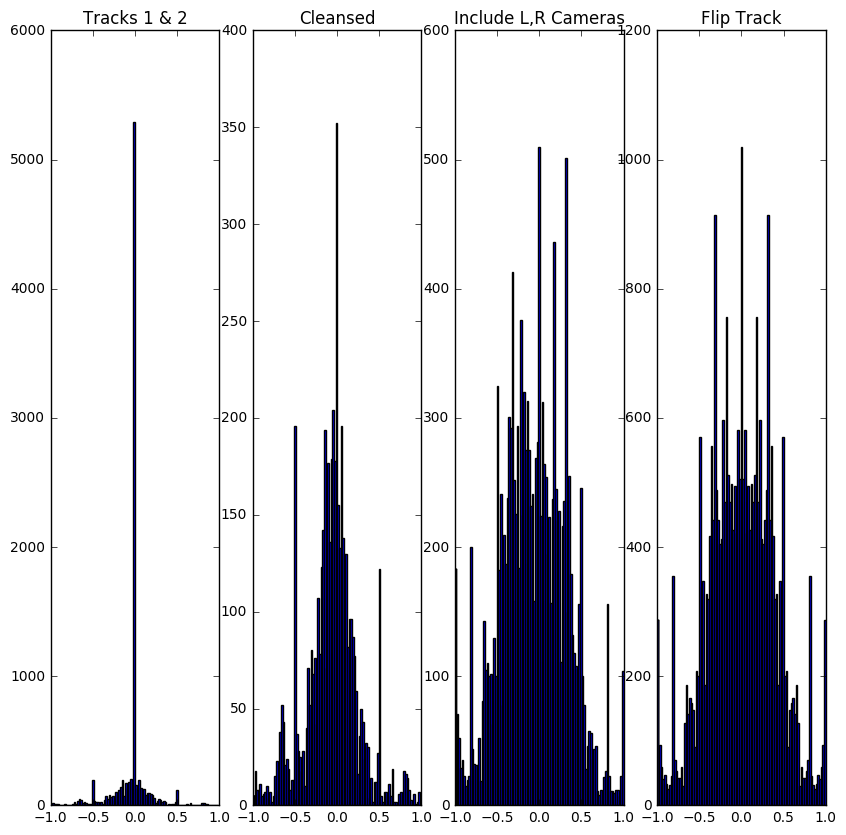

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

gs2 = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(10,10))

porig = plt.subplot(1,4,1)
o = plt.hist(y_data, bins=n_classes)
t = porig.set_title("Tracks 1 & 2")

porigd = plt.subplot(1,4,2)
od = plt.hist(cleansed['steering'], bins=n_classes)
td = porigd.set_title("Cleansed")

#x_data,y_data = downsample(combined['center'], y_data, n_classes, 400)
x_data = cleansed['center']
xl_data = cleansed['left']
xr_data = cleansed['right']
y_data = cleansed['steering']

# Use the L and R cameras
x_cache = []
y_cache = []
correction = std_cleansed
for i in range(len(y_data)):
    l,r = min(y_data[i]+correction,1.0), max(y_data[i]-correction, -1.0) #adjust_steering(n_classes, y_data[i])
    y_cache = y_cache + [y_data[i], l, r]
    x_cache = x_cache + [x_data[i], xl_data[i], xr_data[i]]
y_upsampled = np.array(y_cache)
x_upsampled = np.array(x_cache)

ds = plt.subplot(1,4,3)
o = plt.hist(y_upsampled, bins=n_classes)
t = ds.set_title("Include L,R Cameras")

# Flip images and steering
x_cache = []
y_cache = []
for i in range(len(y_upsampled)):
    y   = y_upsampled[i]
    y_n = -1*y_upsampled[i] #+(n_classes-1)
    y_cache = y_cache + [y_n]
y_flipped = np.append(y_upsampled, y_cache)#np.array(y_cache)

ds = plt.subplot(1,4,4)
o = plt.hist(y_flipped, bins=n_classes)
t = ds.set_title("Flip Track")
print(x_data[2000],y_data[2000], len(y_flipped))


In [ ]:
sample_means = sample_logits(x_data)
print("Means \tRed \tGreen \tBlue")
print(sample_means[0],"\t",sample_means[1],"\t",sample_means[2])

In [ ]:
from ImageProcessing import gaussian_blur, grayscale, canny, weighted_img, image_gradient, get_viewport
import cv2
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

file = "data/IMG/center_2017_02_03_14_01_20_039.jpg"
image = mpimg.imread(file)
image_pil = Image.open(file)
image_cv2 = cv2.imread(file)
image_flipped = cv2.flip(image,1)
image_thumb = get_viewport(image)
image_thumb_bw = image_gradient(image_thumb)
#image, np.asarray(image_pil), image_cv2, image_cv2[:, :, ::-1]
cv2.imshow("Matplotlib", image)
cv2.imshow("Pillow", np.asarray(image_pil))
cv2.imshow("OpenCV BGR", image_cv2)
cv2.imshow("OpenCV RGB", image_cv2[:, :, ::-1])
cv2.imshow("OpenCV Flipped", image_flipped)
cv2.imshow("OpenCV Flipped (RGB)", image_flipped[:, :, ::-1])
cv2.imshow("Thumbnail", image_thumb)
cv2.imshow("Thumbnail B/W", image_thumb_bw)

# Close figure window and click on other window 
# Then press any keyboard key to close all windows
closeWindow = -1
while closeWindow<0:
    closeWindow = cv2.waitKey(1) 
cv2.destroyAllWindows()


### Pre-process images to Pickle dumps

In [10]:
from ImageProcessing import gaussian_blur, grayscale, canny, weighted_img, image_gradient
import cv2
import matplotlib.image as mpimg
from PIL import Image
import pickle

use_side_views = False

x_data  = cleansed['center']
y_data  = cleansed['steering']
xl_data = cleansed['left']
xr_data = cleansed['right']

# Use the L and R cameras
x_cache = []
xbw_cache = []
y_cache = []
correction = std_cleansed/2
for i in range(len(y_data)):
    #c,l,r = y_data[i], min(y_data[i]+correction, 1.0), max(y_data[i]-correction,-1.0)
    c,l,r = y_data[i], correction, -1*correction
    #adjust_steering(n_classes, y_data[i])
    #Read images
    x = mpimg.imread(image_file(x_data[i]))
    
    #Crop and Resize
    x_cropped = get_viewport(x)           #Size is changed for VGG16, size=(112,112)
    
    #Morphology filter
    x_bw = image_gradient(x_cropped, channels=1)
    
    #Without L/R cameras
    if use_side_views:
        #Load side views
        xl = mpimg.imread(image_file(xl_data[i]))
        xr = mpimg.imread(image_file(xr_data[i]))
        #Crop
        xl_cropped = get_viewport(xl)
        xr_cropped = get_viewport(xr)
        # grab image gradient
        xl_bw = image_gradient(xl_cropped, channels=1)
        xr_bw = image_gradient(xr_cropped, channels=1)
        #add to cache
        x_cache = x_cache + [x_cropped, xl_cropped, xr_cropped]
        xbw_cache = xbw_cache + [x_bw, xl_bw, xr_bw]
        y_cache = y_cache + [c, l, r]
    else:
        x_cache = x_cache + [x_cropped]
        xbw_cache = xbw_cache + [x_bw]
        y_cache = y_cache + [c]
    
    if i%500 == 0:
        print(i)
    else:
        if i%10 == 0:
            print(".", end="")
y_upsampled = np.array(y_cache)
x_upsampled = np.array(x_cache)
xbw_upsampled = np.array(xbw_cache)

#Pickle the augmented data to save time
pickle_dict = {'features': x_upsampled, 'labels': y_upsampled}
pickle.dump(pickle_dict, open("./training_data.p", "wb"))

pickle_dict = {'features': xbw_upsampled, 'labels': y_upsampled}
pickle.dump(pickle_dict, open("./training_data_bw.p", "wb"))

0
.................................................500
.................................................1000
.................................................1500
.................................................2000
.................................................2500
.................................................3000
.................................................3500
.................................................4000
.................................................4500
.................................................5000
.....

### Train Simple Model with direct datasets (no sample flipping)

In [ ]:
print("Image normalization...")
x_train = x_upsampled/255 - 0.5
print("Label scaling for 1-hot encoding...")
y_train = scale_labels(y_upsampled, n_classes)
y_train = to_categorical(y_train, n_classes)

print("Generating Training, Validation Data Full")
x_train, y_train, x_val, y_val = create_datasets(x_train, y_train, n_classes=n_classes, test=False)
print(len(x_train), len(x_val))

print("Building Classifier...")
#default_shape = (None,112,112,3)
#classifier = combined_model(default_shape, n_classes=n_classes)
shape = (None,20,80,3)
classifier = simple_model(shape, n_classes=n_classes)

print("Training Classifier...")
classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = classifier.fit(x_train,y_train,batch_size=256,nb_epoch=20,verbose=1,validation_data=(x_val, y_val))
classifier.save_weights('model_weights.h5')
classifier.save('model.h5')

print("Done!")


### Train Model with Generator for Image Flipping

In [11]:
import cv2
from keras.utils.np_utils import to_categorical

########################################################################
# This generator loads images and from disk and generate variants
########################################################################
def gen(data, labels, batch, n_classes):
    #2/3 of images in the batch come from L/R viewports
    batch_size = int(batch / 2) 
    def _f():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            x_batch, y_batch = data[start:end], labels[start:end]
            #print(x_batch.shape, y_batch.shape)
            #Balance the dataset by flipping samples
            flip_image_cache = []
            flip_label_cache = []
            for img, label in zip(x_batch, y_batch):
                img = cv2.flip(img,1)
                flip_image_cache = flip_image_cache + [img]
                label = -1 * label
                flip_label_cache = flip_label_cache + [label]
            x_batch = np.append(x_batch, flip_image_cache, axis=0)
            y_batch = np.append(y_batch, flip_label_cache)
            #print(x_batch.shape, y_batch.shape)
            
            #Preprocess data for training
            x_batch = x_batch/255 - 0.5
            y_batch = scale_labels(y_batch, n_classes)
            y_batch = to_categorical(y_batch, n_classes)
            start += batch_size
            end += batch_size
            if start >= n:
                start = 0
                end = batch_size
            #print(start, end)
            yield (x_batch, y_batch)
    return _f

########################################################################
# Train the classifier
########################################################################
def train_classifier(model, x_train, y_train, x_val, y_val, n_classes, batch, epochs):
    # Compile and train the model here.
    train_gen = gen(x_train, y_train, batch, n_classes)
    val_gen = gen(x_val, y_val, batch, n_classes)
    #Expect the generator to create 4 additional views from each image
    samples    = 2*len(x_train)
    val_samples= 2*len(x_val)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    history = model.fit_generator(train_gen(), samples_per_epoch=samples, nb_epoch=epochs, verbose=1, validation_data=val_gen(), nb_val_samples=val_samples)
    model.save_weights('model_weights.h5')
    model.save('model.h5')

#Split dataset
print("Generating Training, Validation Data Full")
x_train, y_train, x_val, y_val = create_datasets(x_upsampled, y_upsampled, n_classes=n_classes, test=False)
print(len(x_train), len(x_val))

# Start the training
print("Building Classifier...")
default_shape = (None,112,112,3)
#classifier = combined_model(default_shape, n_classes=n_classes)
shape = (None,20,80,3)
classifier = simple_model(shape, n_classes=n_classes)

print("Training Classifier...")
train_classifier(classifier, x_train, y_train, x_val, y_val, n_classes=n_classes, batch=512, epochs=25)
print("Done!")


Generating Training, Validation Data Full
4545 506
Building Classifier...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
block1_conv1 (Convolution2D)     (None, 20, 80, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
block1_pool (AveragePooling2D)   (None, 10, 40, 32)    0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block2_conv1 (Convolution2D)     (None, 10, 40, 64)    18496       block1_pool[0][0]                
____________________________________________________________________________________________________
block2_pool (AveragePooling2D)   (None, 5, 20, 64)     0           block2_conv1[0][0]               
_________________

In [ ]:
# Retrain the model for an additional 20 epochs

def tune_classifier(model, x_train, y_train, x_val, y_val, n_classes, batch, epochs):
    # Compile and train the model here.
    train_gen = gen(x_train, y_train, batch, n_classes)
    val_gen = gen(x_val, y_val, batch, n_classes)
    #Expect the generator to create 4 additional views from each image
    samples    = 2*len(x_train)
    val_samples= 2*len(x_val)
    #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    history = model.fit_generator(train_gen(), samples_per_epoch=samples, nb_epoch=epochs, verbose=1, validation_data=val_gen(), nb_val_samples=val_samples)
    model.save_weights('model_weights.h5')
    model.save('model.h5')

classifier.summary()
print("Tuning Classifier...")
tune_classifier(classifier, x_train, y_train, x_val, y_val, n_classes=n_classes, batch=512, epochs=20)
print("Done!")


In [ ]:
predictions = classifier.predict(x_train[1000:1100], batch_size=20)
for prediction in zip(predictions):
    print(np.argmax(prediction), end=",")

### Train VGG16 + Custom Classifier with direct datasets (no sample flipping)

In [ ]:
from keras.applications.imagenet_utils import preprocess_input

print("Image normalization...")
x_train = preprocess_input(x_upsampled.astype("float64"))
print("Label scaling for 1-hot encoding...")
y_train = scale_labels(y_upsampled, n_classes)
y_train = to_categorical(y_train, n_classes)

print("Generating Training, Validation Data Full")
x_train, y_train, x_val, y_val = create_datasets(x_train, y_train, n_classes=n_classes, test=False)
print(len(x_train), len(x_val))

print("Building Classifier...")
default_shape = (None,112,112,3)
classifier = combined_model(default_shape, n_classes=n_classes)

print("Training Classifier...")
classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = classifier.fit(x_train,y_train,batch_size=64,nb_epoch=10,verbose=1,validation_data=(x_val, y_val))
classifier.save_weights('model.h5')

print("Done!")

def combined_model_file(shape, n_classes):
    #Load VGG16 without FC layers and add AveragePooling
    input_tensor = Input(shape=shape[1:])
    vgg16 = VGG16(input_tensor=input_tensor, include_top=False)
    x = vgg16.output
    x = AveragePooling2D((2,2), name='vgg_pool')(x)
    vgg16 = Model(vgg16.input, x)
    
    #Create the classifier
    classifier = Sequential()
    flatten_layer = Flatten(input_shape=vgg16.output_shape[1:])
    flatten_layer(x)
    classifier.add(flatten_layer)
    classifier.add(Dense(512, init='normal', activation='relu', name='fc_512'))
    classifier.add(Dense(256, init='normal', activation='relu', name='fc_256'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(n_classes, init='normal', activation='softmax', name='fc_output'))
    # Load pretrained weights
    # topper.load_weights('fc_model.h5')
    model = Model(vgg16.input, classifier.output)
    model.summary()
    #Save Model architecture to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    return model

default_shape = (None,112,112,3)
classifier_save = combined_model_file(default_shape, n_classes=n_classes)


### Train with a generator to flip samples